# Building Pipeline For Hacker News Search API. #

---

## Purpose of this project: ##

The objective is to showcase my familiarity with general pipeline struture to clean and preprocess the collected data from [Hacker News Search API][1]. [Here's][2] the link to the data collection process. 

__Background info:__

Hacker News is a sites where people can share stories, sites, and articles or ask questions or post hiring notices.


## Table of content: ##

* Setting up Pipeline structure and do a test run. 
    * [Create 'Pipeline' and 'Directed Acyclic Graph' class.](#Create-'Pipeline'-and-'Directed-Acyclic-Graph'-class.)
    * [Do a test run with the created 'Pipeline'.](#Do-a-test-run-with-the-created-'Pipeline'.)
* Data exploration.
    * [Explore the dataset and transform the data types.](#Explore-the-dataset-and-transform-the-data-types.)
    * [Summarise the data and visualise the distribution.](#Summarise-the-data-and-visualise-the-distribution.)
* Data cleaning.
    * [Extract the domain names and create 'type' column to indicate story type.](#Extract-the-domain-names-and-create-'type'-column-to-indicate-story-type.)
    * [Work on the missing data.](#Work-on-the-missing-data.)
* [Demonstrate using 'Pipeline' to chain all the functions together.](#Demonstrate-using-'Pipeline'-to-chain-all-the-functions-together.)
* [Notes for future reference.](#Notes-for-future-reference.)
    
[1]:https://hn.algolia.com/api
[2]:https://nbviewer.jupyter.org/github/lionelcub/applying_API_requests_on_hacker_news_search_API/blob/master/applying_API_requests_on_hacker_news_search_API.ipynb

In [1]:
from collections import deque

## Create 'Pipeline' and 'Directed Acyclic Graph' class. ##

Return to [Table of content:](#Table-of-content:)

---

__Overview on creating the `Pipeline` class:__

In order to build a pipeline, I need to create a structure such that the output of one function will become the input of another function and it will keep running until all the functions are complete. 

The `Directed Graph` class will contain a list of ordered functions, while the `Pipeline` class will run the each function in a sequential order. The order will depend on the structure of the `Directed Graph`. Each function's output will be stored in a dictionary so that I can display the output later if I need to do a double check. I will also create metrics so that I can track and monitor the internal process while executing multiple functions with `Pipeline`. 

__There are 2 ways to create the `Directed Graph` in order to run the `Pipeline`:__
1. I can utilise the python `decorator`/`wrapper`. 
2. I can manually build the `Directed Graph` by specifying the function name. 

__What this `Pipeline` can do:__
1. Able to take more than 1 output from previous function as argument. 
2. Able to limit the number of outputs from previous function that will be taken as input for the subsequent function.
3. Able to include keyword arguments. 
4. It has option to create a checkpoint by saving function's output into files. 
5. Able to run the `Pipeline` starting from a specific function.
6. It stores all functions' outputs in a `dict` object so I can display them later.
7. It stores information on the connections/links between each functions. 
8. It stores the running order of all the functions. 

---
__Setting up `Directed Graph` class.__

In [2]:
# To contain a structure of ordered functions.
class Directed_Acyclic_Graph():
    def __init__(self):
        # Create a 'Directed Graph' by mapping each function to its child functions.
        self.graph = {}
        # Map the child function to its parent functions.
        self.parent_func = {}
        # Store the number of outputs to take as input when running the child function.
        self.n_outputs = {}
        
    # Add a link between each function to its subsequent functions.
    def add(self, parent_func, to=None, n_outputs=1):
        # Store the parent function as the key and the 'to' function as value in a list. 
        if not isinstance(parent_func, list):
            parent_func = [parent_func]
        for func in parent_func:
            if func not in self.graph:
                self.graph[func] = []
                self.parent_func[func] = []
            if to:
                if to not in self.graph:
                    self.graph[to] = []
                    self.parent_func[to] = []
                self.n_outputs[to] = n_outputs
                self.parent_func[to].append(func)
                self.graph[func].append(to)
            else:
                self.n_outputs[func] = n_outputs
            
        # If the graph is cyclical, raise an error.
        if len(self.sort()) != len(self.graph):
            raise Exception("Graph structure must not be cyclical, please correct it.")
    
    # Count the in-degree of each function.
    def in_degree_count(self):
        in_degree_count = {}
        
        for child_func, ls in self.parent_func.items():
            in_degree_count[child_func] = len(ls)
        
        # Store a copy of the 'in_degree_count' dict,
        # because the original 'in_degree_count' will be removed after applying 'sort()' method.
        self.inDegree_count = in_degree_count.copy()
        return in_degree_count
    
    # Sort the function based on the 'in_degree' counts in ascending order.
    def sort(self):
        queue = deque() 
        in_degree_count = self.in_degree_count()
        
        # Start by appending functions that has 0 in-degree,
        # because they are the first to execute. 
        for func, count in in_degree_count.items():
            if count == 0:
                queue.append(func)
        
        # Store function in 'searched' list if the `in_degree` counts are reduced to 0.
        # So function that has the highest 'in_degree' counts will be in the last order,
        # because that function depends on the output of other functions. 
        # Example: 2nd function might depend on the output of the 1st function,
        # so the 1st function must be executed first before the 2nd function. 
        self.searched = []
        while queue:
            popped_func = queue.popleft()
            if self.graph[popped_func]:
                for mapped_func in self.graph[popped_func]:
                    in_degree_count[mapped_func] -= 1
                    if in_degree_count[mapped_func] == 0:
                        queue.append(mapped_func)
            self.searched.append(popped_func)
        return self.searched

__Setting up `Pipeline` class.__

In [3]:
# To run the each function in a sequential order.
class Pipeline():
    def __init__(self):
        self.tasks = Directed_Acyclic_Graph()
        self.outputs = {}
        self.n_outputs = {}
        # Store additional kwargs for each function if available.
        self.kwargs = {}
    
    # Add a link between each parent and child functions.
    # Add keyword arguments if availble.
    # Refer to 'Directed_Acyclic_Graph.add()' method attribute.
    def task(self, depends_on=None, n_outputs=1, **kwargs):
        def inner_func(func):
            if kwargs:
                self.kwargs[func] = kwargs
            if not depends_on:
                self.tasks.add(func, n_outputs=n_outputs)
            else:
                self.tasks.add(depends_on, to=func, n_outputs=n_outputs)
            return func
        return inner_func
    
    # Create 'checkpoint' to save each funtion's output to a file. 
    # This avoid having to rerun the entire pipeline if error occurs in between.
    def checkpoint(self, file_name, data=None):
        import csv
        import json
        import pandas as pd

        if isinstance(data, pd.DataFrame):
            data.to_csv("checkpoints/{}.csv".format(file_name), index=False)

        elif isinstance(data, dict):
            with open('checkpoints/{}.json'.format(file_name), "w") as writer:
                json.dump(data, writer)
                
        else: 
            # If the data is not a list of list, then conver it. 
            if not isinstance(data, list) or isinstance(data, tuple):
                data = [[data]]
            elif not isinstance(data[0], list) or isinstance(data[0], tuple):
                data = [data]
                
            with open('checkpoints/{}.csv'.format(file_name), "w") as write_file:
                writer = csv.writer(write_file, delimiter=',')
                writer.writerows(data)
    
    # Run each function in order. 
    # Refer to 'Directed_Acyclic_Graph.sort()' method. 
    def run(self, start_func=None, checkpoint=True, output_to_save=1):
        tasks_order = self.tasks.searched
        self.n_outputs = self.tasks.n_outputs
        idx = 0
        id_func = 0
        
        if start_func is not None:
            for i, task in enumerate(tasks_order): 
                if task == start_func: 
                    idx = i
                    id_func = idx
                    break
        
        for i, task in enumerate(tasks_order[idx:]):
            id_func += 1
            args_parent_func = []
            kwargs = {}
            if task in self.kwargs:
                kwargs = self.kwargs[task]
            
            # If the task has no in-degree, simply execute the function.
            # Else, find the parent function the task depends on.
            # When found, run the task with that function's output(s) as argument(s),
            # The number of outputs taken as inputs is based on the 'self.tasks.n_outputs' dict.
            # Store each function's output in 'self.outputs' dict. 
            if self.tasks.inDegree_count[task] == 0:
                self.outputs[task] = task(**kwargs)
            else:
                for parent_func in self.tasks.parent_func[task]:
                    n_outputs = self.n_outputs[parent_func]
                    for output in self.outputs[parent_func]:
                        while n_outputs != 0:
                            args_parent_func.append(output)
                            n_outputs -= 1
            self.outputs[task] = task(*args_parent_func, **kwargs)
            
            # Save the output(s) as checkpoint. 
            if checkpoint:
                output_saved = 0
                for n, output in enumerate(self.outputs[task]):
                    file_name = "{}_{}_R{}".format(id_func, task.__name__, n+1)
                    self.checkpoint(file_name, data=output)
                    output_saved += 1
                    if output_to_save == output_saved:
                        break
        return self.outputs

## Do a test run with the created 'Pipeline'. ##

Return to [Table of content:](#Table-of-content:)

---

__Setting up a function to check the internal `Graph` object.__

In [4]:
def check_internal_graph(pipeline, output=True):
    from pprint import pprint as pp
    
    checklists = {
        "Graph": pipeline.tasks.graph, "Parent Function":pipeline.tasks.parent_func, 
        "InDegree Count": pipeline.tasks.inDegree_count, 
        "Function Running Order": pipeline.tasks.searched, "Keyword arguments": pipeline.kwargs, 
        "N Outputs": pipeline.tasks.n_outputs} 
    
    if output == True:
        for checklist, result in checklists.items():
            print("{}: ".format(checklist))
            pp("{}".format(result))
            print("\n")
    return checklists

__Apply `decorator` to run the `pipeline`.__

In [5]:
pipeline = Pipeline()

@pipeline.task()
def first():
    data = 10
    return (data,)

# 'first' ---> 'second'. There are 2 'return values' but only 1 will be taken as input.
@pipeline.task(depends_on=first, n_outputs=1)
def second(x):
    data = x * 2
    return (data, x)

# 'second' ---> 'third'. 'third' also has 2 extra parameters. 
@pipeline.task(depends_on=second, y=4, z=4)
def third(x, y, z):
    data = x * y * z
    return (data,)

# 'second' & 'third' ---> 'fourth'.
@pipeline.task(depends_on=[second, third])
def fourth(x, y):
    data = x * y
    return (data,)

outputs = pipeline.run()
outputs

{<function __main__.first()>: (10,),
 <function __main__.second(x)>: (20, 10),
 <function __main__.third(x, y, z)>: (320,),
 <function __main__.fourth(x, y)>: (6400,)}

---
__Add another function and run the `pipeline` starting from that function without rerunning entirely.__

In [6]:
# 'fourth' ---> 'fifth'.
@pipeline.task(depends_on=fourth)
def fifth(x):
    data = x * 10
    return (data,)

In [7]:
outputs = pipeline.run(start_func=fifth)
outputs

{<function __main__.first()>: (10,),
 <function __main__.second(x)>: (20, 10),
 <function __main__.third(x, y, z)>: (320,),
 <function __main__.fourth(x, y)>: (6400,),
 <function __main__.fifth(x)>: (64000,)}

---
__Check the internal `Graph` object.__

In [8]:
check_internal_graph(pipeline)

Graph: 
('{<function first at 0x110650488>: [<function second at 0x1106500d0>], '
 '<function second at 0x1106500d0>: [<function third at 0x110650048>, '
 '<function fourth at 0x110650510>], <function third at 0x110650048>: '
 '[<function fourth at 0x110650510>], <function fourth at 0x110650510>: '
 '[<function fifth at 0x120808f28>], <function fifth at 0x120808f28>: []}')


Parent Function: 
('{<function first at 0x110650488>: [], <function second at 0x1106500d0>: '
 '[<function first at 0x110650488>], <function third at 0x110650048>: '
 '[<function second at 0x1106500d0>], <function fourth at 0x110650510>: '
 '[<function second at 0x1106500d0>, <function third at 0x110650048>], '
 '<function fifth at 0x120808f28>: [<function fourth at 0x110650510>]}')


InDegree Count: 
('{<function first at 0x110650488>: 0, <function second at 0x1106500d0>: 1, '
 '<function third at 0x110650048>: 1, <function fourth at 0x110650510>: 2, '
 '<function fifth at 0x120808f28>: 1}')


Function Running Ord

{'Graph': {<function __main__.first()>: [<function __main__.second(x)>],
  <function __main__.second(x)>: [<function __main__.third(x, y, z)>,
   <function __main__.fourth(x, y)>],
  <function __main__.third(x, y, z)>: [<function __main__.fourth(x, y)>],
  <function __main__.fourth(x, y)>: [<function __main__.fifth(x)>],
  <function __main__.fifth(x)>: []},
 'Parent Function': {<function __main__.first()>: [],
  <function __main__.second(x)>: [<function __main__.first()>],
  <function __main__.third(x, y, z)>: [<function __main__.second(x)>],
  <function __main__.fourth(x, y)>: [<function __main__.second(x)>,
   <function __main__.third(x, y, z)>],
  <function __main__.fifth(x)>: [<function __main__.fourth(x, y)>]},
 'InDegree Count': {<function __main__.first()>: 0,
  <function __main__.second(x)>: 1,
  <function __main__.third(x, y, z)>: 1,
  <function __main__.fourth(x, y)>: 2,
  <function __main__.fifth(x)>: 1},
 'Function Running Order': [<function __main__.first()>,
  <function _

---
__Check whether each function's output is saved to CSV file.__

In [9]:
from glob import glob
glob("checkpoints/*.csv")

['checkpoints/7_fill_na_R1.csv',
 'checkpoints/1_first_R1.csv',
 'checkpoints/5_fifth_R1.csv',
 'checkpoints/4_fourth_R1.csv',
 'checkpoints/2_second_R1.csv',
 'checkpoints/3_third_R1.csv',
 'checkpoints/5_create_new_data_with_regex_R1.csv']

---
__Alternative way to run the `pipeline` just by specifying the function name only.__

In [10]:
pipeline = Pipeline()

pipeline.tasks.add(first)
pipeline.tasks.add(parent_func=first, to=second, n_outputs=1)
pipeline.tasks.add(parent_func=second, to=third)
pipeline.tasks.add(parent_func=[second, third], to=fourth)

# Set the kwargs for 'third' function only. 
pipeline.kwargs = {
    third: {"y":4, "z":4}
}

outputs = pipeline.run()
outputs

{<function __main__.first()>: (10,),
 <function __main__.second(x)>: (20, 10),
 <function __main__.third(x, y, z)>: (320,),
 <function __main__.fourth(x, y)>: (6400,)}

---
__Add another function and run the `pipeline` starting from that function without rerunning entirely.__

In [11]:
pipeline.tasks.add(parent_func=fourth, to=fifth)

outputs = pipeline.run(start_func=fifth)
outputs

{<function __main__.first()>: (10,),
 <function __main__.second(x)>: (20, 10),
 <function __main__.third(x, y, z)>: (320,),
 <function __main__.fourth(x, y)>: (6400,),
 <function __main__.fifth(x)>: (64000,)}

---
__Check the internal `Graph` object.__

In [12]:
check_internal_graph(pipeline)

Graph: 
('{<function first at 0x110650488>: [<function second at 0x1106500d0>], '
 '<function second at 0x1106500d0>: [<function third at 0x110650048>, '
 '<function fourth at 0x110650510>], <function third at 0x110650048>: '
 '[<function fourth at 0x110650510>], <function fourth at 0x110650510>: '
 '[<function fifth at 0x120808f28>], <function fifth at 0x120808f28>: []}')


Parent Function: 
('{<function first at 0x110650488>: [], <function second at 0x1106500d0>: '
 '[<function first at 0x110650488>], <function third at 0x110650048>: '
 '[<function second at 0x1106500d0>], <function fourth at 0x110650510>: '
 '[<function second at 0x1106500d0>, <function third at 0x110650048>], '
 '<function fifth at 0x120808f28>: [<function fourth at 0x110650510>]}')


InDegree Count: 
('{<function first at 0x110650488>: 0, <function second at 0x1106500d0>: 1, '
 '<function third at 0x110650048>: 1, <function fourth at 0x110650510>: 2, '
 '<function fifth at 0x120808f28>: 1}')


Function Running Ord

{'Graph': {<function __main__.first()>: [<function __main__.second(x)>],
  <function __main__.second(x)>: [<function __main__.third(x, y, z)>,
   <function __main__.fourth(x, y)>],
  <function __main__.third(x, y, z)>: [<function __main__.fourth(x, y)>],
  <function __main__.fourth(x, y)>: [<function __main__.fifth(x)>],
  <function __main__.fifth(x)>: []},
 'Parent Function': {<function __main__.first()>: [],
  <function __main__.second(x)>: [<function __main__.first()>],
  <function __main__.third(x, y, z)>: [<function __main__.second(x)>],
  <function __main__.fourth(x, y)>: [<function __main__.second(x)>,
   <function __main__.third(x, y, z)>],
  <function __main__.fifth(x)>: [<function __main__.fourth(x, y)>]},
 'InDegree Count': {<function __main__.first()>: 0,
  <function __main__.second(x)>: 1,
  <function __main__.third(x, y, z)>: 1,
  <function __main__.fourth(x, y)>: 2,
  <function __main__.fifth(x)>: 1},
 'Function Running Order': [<function __main__.first()>,
  <function _

## Explore the dataset and transform the data types. ##

Return to [Table of content:](#Table-of-content:)

In [13]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pd.set_option("display.max_columns", 100, "display.max_rows", 100, "display.max_colwidth", 500)

# Pre-configure the plotting style. 
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12)
plt.style.use('seaborn-colorblind')

sns.set_style('darkgrid')

__Here's the data dictionary:__ 

1. __objectID:__ An unique ID for each story.
1. __title:__ Title of the story. 
1. __created_at:__ Date and time the story is created at. 
1. __points:__ Number of votes. 
1. __num_comments:__ Number of comments.
1. __url:__ Referred url by the author.

---
__Initiate the `Pipeline` class.__

In [14]:
pipeline = Pipeline()

__Explore the dataset.__

In [15]:
def dataset_detail(filename):
    from scipy import stats
    
    df = pd.read_csv("{}".format(filename)) 
    
    # Find null proportion. 
    nulls = round(df.isnull().sum() / df.shape[0] * 100, 2)
    # Find duplicates.
    duplicated = df[df.duplicated()]
    
    detail = {
        "Columns": df.columns,
        "Dtypes": df.dtypes,
        "Shape": df.shape,
        "Nulls": nulls
    }
    return (df, detail, duplicated)

In [16]:
# Add into the 'Pipeline'.
func = dataset_detail
pipeline.kwargs[func] = {"filename": "csv/hn_stories.csv"}
pipeline.tasks.add(func, n_outputs=1)
pipeline.run(start_func=func, checkpoint=False)

hn_stories = pipeline.outputs[func][0]
hn_stories

,objectID,title,created_at,points,num_comments,url
0,21495338,Rust 2020: GUI and Community,2019-11-09T23:46:07.000Z,152,37,https://raphlinus.github.io/rust/druid/2019/10/31/rust-2020.html
1,21494673,Viral Tweet About Apple Card Leads to Goldman Sachs Probe,2019-11-09T21:57:36.000Z,129,148,https://www.bloomberg.com/news/articles/2019-11-09/viral-tweet-about-apple-card-leads-to-probe-into-goldman-sachs
2,21494295,Narcissistic CEOs weaken collaboration and integrity,2019-11-09T20:56:58.000Z,150,80,https://www.gsb.stanford.edu/insights/narcissistic-ceos-weaken-collaboration-integrity
3,21493761,"Fast Markov chains in ~20 lines of sh, grep, cut and Awk",2019-11-09T19:37:40.000Z,292,34,https://0x0f0f0f.github.io/posts/2019/11/really-fast-markov-chains-in-~20-lines-of-sh-grep-cut-and-awk/
4,21493410,Show HN: LuaJIT assembler/assembly language for direct bytecode programming,2019-11-09T18:49:07.000Z,127,20,https://github.com/rochus-keller/LjTools
...,...,...,...,...,...,...
995,21282680,DoNotPay app waits on hold for you,2019-10-17T14:53:39.000Z,130,82,https://techcrunch.com/2019/10/16/avoid-waiting-on-hold/
996,21282647,Haskell in Production,2019-10-17T14:50:57.000Z,200,237,http://felixmulder.com/writing/2019/10/05/Haskell-in-Production.html
997,21282009,OpenBSD 6.6,2019-10-17T13:49:36.000Z,224,89,https://www.openbsd.org/66.html
998,21281724,DNS 101: An Introduction to Domain Name Servers,2019-10-17T13:21:45.000Z,250,38,https://www.redhat.com/sysadmin/dns-domain-name-servers


---
__Explore the detail of the dataset.__

In [17]:
for key, output in pipeline.outputs[func][1].items():
    print("\n\n{}: \n{}".format(key, output))



Columns: 
Index(['objectID', 'title', 'created_at', 'points', 'num_comments', 'url'], dtype='object')


Dtypes: 
objectID         int64
title           object
created_at      object
points           int64
num_comments     int64
url             object
dtype: object


Shape: 
(1000, 6)


Nulls: 
objectID        0.0
title           0.0
created_at      0.0
points          0.0
num_comments    0.0
url             3.4
dtype: float64


---
__Findings:__

The `url` has 3.4% of null columns, while the rest doesn't contain any null value. It might be that the author did not provide any referral url for the reader rather than an error or mistake. I will fix that at later stage of the `pipeline`.

__Check if there is any duplicated rows.__

In [18]:
pipeline.outputs[func][2]

,objectID,title,created_at,points,num_comments,url


---
__Transform data types before creating a statistical summary of the dataset.__

In [19]:
def transform_dtypes( 
    df, obj_convert_cols=None, dt_convert_cols=None, dt_first='year', dt_only=True,
    num_convert_cols=None, cat_convert_cols=None, cat_order=[None]
    ):
    import re
    
    data_copy = df.copy()

    # Convert column to object dtype.
    if obj_convert_cols:
        for col in obj_convert_cols:
            data_copy[col] = data_copy[col].astype('object')
        
    # Convert column to datetime dtype.
    if dt_convert_cols:
        for col in dt_convert_cols:
            if dt_first == 'year':
                data_copy[col] = pd.to_datetime(data_copy[col], yearfirst=True)
            elif dt_first == 'day':
                data_copy[col] = pd.to_datetime(data_copy[col], dayfirst=True)
            elif dt_first == 'infer':
                data_copy[col] = pd.to_datetime(data_copy[col], infer_datetime_format=True)
            if dt_only:
                data_copy[col] = data_copy[col].dt.normalize()
    
    # Convert column to or downcast numeric dtype.
    if num_convert_cols:
        for col in num_convert_cols:
            dtype = re.findall(r"(\D+)", str(data_copy[col].dtype))
            if dtype[0] == 'int':
                dtype[0] = 'integer'
            data_copy[col] = pd.to_numeric(data_copy[col], downcast=dtype[0])
        
    # Convert column to or categorical dtype.
    if cat_convert_cols:
        for i, col in enumerate(cat_convert_cols):
            data_copy[col] = pd.Categorical(data_copy[col])
            # The 'cat_order' should list of list.
            if cat_order[i] is not None:
                # Assign values to list to reorder the ordinal values if given. 
                data_copy[col].cat.categories = cat_order[i] 
    
    # Split the columns into categorical and numerical. 
    # To make it easier to manage the data and do cleaning later.
    cols_by_dtypes = {
        "categorical_cols": data_copy.select_dtypes(include=['O']).columns,
        "ordinal_cols": data_copy.select_dtypes(include=['category', 'datetime']).columns,
        "numerical_cols": data_copy.select_dtypes(include=['number']).columns
    }
    return (data_copy, data_copy.dtypes, cols_by_dtypes)

In [20]:
# Add into the 'Pipeline'.
func = transform_dtypes
pipeline.kwargs[func] = {
    "obj_convert_cols": ["objectID"],
    "num_convert_cols": ["points", "num_comments"],
    "dt_convert_cols": ["created_at"],
    "dt_first": "infer"
}
pipeline.tasks.add(parent_func=dataset_detail, to=func, n_outputs=1)
pipeline.run(start_func=func, checkpoint=False)

pipeline.outputs[func][0]

,objectID,title,created_at,points,num_comments,url
0,21495338,Rust 2020: GUI and Community,2019-11-09 00:00:00+00:00,152,37,https://raphlinus.github.io/rust/druid/2019/10/31/rust-2020.html
1,21494673,Viral Tweet About Apple Card Leads to Goldman Sachs Probe,2019-11-09 00:00:00+00:00,129,148,https://www.bloomberg.com/news/articles/2019-11-09/viral-tweet-about-apple-card-leads-to-probe-into-goldman-sachs
2,21494295,Narcissistic CEOs weaken collaboration and integrity,2019-11-09 00:00:00+00:00,150,80,https://www.gsb.stanford.edu/insights/narcissistic-ceos-weaken-collaboration-integrity
3,21493761,"Fast Markov chains in ~20 lines of sh, grep, cut and Awk",2019-11-09 00:00:00+00:00,292,34,https://0x0f0f0f.github.io/posts/2019/11/really-fast-markov-chains-in-~20-lines-of-sh-grep-cut-and-awk/
4,21493410,Show HN: LuaJIT assembler/assembly language for direct bytecode programming,2019-11-09 00:00:00+00:00,127,20,https://github.com/rochus-keller/LjTools
...,...,...,...,...,...,...
995,21282680,DoNotPay app waits on hold for you,2019-10-17 00:00:00+00:00,130,82,https://techcrunch.com/2019/10/16/avoid-waiting-on-hold/
996,21282647,Haskell in Production,2019-10-17 00:00:00+00:00,200,237,http://felixmulder.com/writing/2019/10/05/Haskell-in-Production.html
997,21282009,OpenBSD 6.6,2019-10-17 00:00:00+00:00,224,89,https://www.openbsd.org/66.html
998,21281724,DNS 101: An Introduction to Domain Name Servers,2019-10-17 00:00:00+00:00,250,38,https://www.redhat.com/sysadmin/dns-domain-name-servers


In [21]:
pipeline.outputs[func][1]

objectID                     object
title                        object
created_at      datetime64[ns, UTC]
points                        int16
num_comments                  int16
url                          object
dtype: object

---
__Display the split between numerical and categorical columns.__

In [22]:
(pipeline.outputs[func][2]["numerical_cols"], 
 pipeline.outputs[func][2]["categorical_cols"], 
 pipeline.outputs[func][2]["ordinal_cols"])

(Index(['points', 'num_comments'], dtype='object'),
 Index(['objectID', 'title', 'url'], dtype='object'),
 Index([], dtype='object'))

## Summarise the data and visualise the distribution. ##

Return to [Table of content:](#Table-of-content:)

---
__Create a statistical summary of the dataset.__

In [23]:
def dataset_summary(df):
    # Find mode and count categorical variability for each column.
    dict_value_counts = {}
    ls_gini = []
    for col in df.columns:
        counts = df[col].value_counts(normalize=True) * 100
        dict_value_counts[col] = counts
        
        gini = 1
        probabilities = df[col].value_counts(normalize=True, dropna=False).items()

        for key, prob in probabilities:
            gini -= (prob ** 2)
        ls_gini.append((col, gini))
    
    df_gini = pd.DataFrame(ls_gini, columns=["columns", "gini"])
    
    detail = {
        "Describe Num.": df.describe(include=np.number),
        "Describe Cat.": df.describe(include=['O']),
        "Cat. Proportion": dict_value_counts,
        "Cat. Variability": df_gini
    }
    return (df, detail)

In [24]:
# Add into the 'Pipeline'.
func = dataset_summary
pipeline.tasks.add(parent_func=transform_dtypes, to=func, n_outputs=1)
pipeline.run(start_func=func, checkpoint=False)

pipeline.outputs[func][0]

,objectID,title,created_at,points,num_comments,url
0,21495338,Rust 2020: GUI and Community,2019-11-09 00:00:00+00:00,152,37,https://raphlinus.github.io/rust/druid/2019/10/31/rust-2020.html
1,21494673,Viral Tweet About Apple Card Leads to Goldman Sachs Probe,2019-11-09 00:00:00+00:00,129,148,https://www.bloomberg.com/news/articles/2019-11-09/viral-tweet-about-apple-card-leads-to-probe-into-goldman-sachs
2,21494295,Narcissistic CEOs weaken collaboration and integrity,2019-11-09 00:00:00+00:00,150,80,https://www.gsb.stanford.edu/insights/narcissistic-ceos-weaken-collaboration-integrity
3,21493761,"Fast Markov chains in ~20 lines of sh, grep, cut and Awk",2019-11-09 00:00:00+00:00,292,34,https://0x0f0f0f.github.io/posts/2019/11/really-fast-markov-chains-in-~20-lines-of-sh-grep-cut-and-awk/
4,21493410,Show HN: LuaJIT assembler/assembly language for direct bytecode programming,2019-11-09 00:00:00+00:00,127,20,https://github.com/rochus-keller/LjTools
...,...,...,...,...,...,...
995,21282680,DoNotPay app waits on hold for you,2019-10-17 00:00:00+00:00,130,82,https://techcrunch.com/2019/10/16/avoid-waiting-on-hold/
996,21282647,Haskell in Production,2019-10-17 00:00:00+00:00,200,237,http://felixmulder.com/writing/2019/10/05/Haskell-in-Production.html
997,21282009,OpenBSD 6.6,2019-10-17 00:00:00+00:00,224,89,https://www.openbsd.org/66.html
998,21281724,DNS 101: An Introduction to Domain Name Servers,2019-10-17 00:00:00+00:00,250,38,https://www.redhat.com/sysadmin/dns-domain-name-servers


In [25]:
pipeline.outputs[func][1].keys()

dict_keys(['Describe Num.', 'Describe Cat.', 'Cat. Proportion', 'Cat. Variability'])

---
__Summarise numerical data.__

In [26]:
pipeline.outputs[func][1]["Describe Num."]

,points,num_comments
count,1000.000000,1000.000000
mean,256.817000,132.411000
std,209.339811,118.371669
min,101.000000,1.000000
25%,137.750000,51.000000
50%,185.000000,97.500000
75%,295.000000,176.250000
max,2447.000000,1001.000000


---
__Summarise categorical data.__

In [27]:
pipeline.outputs[func][1]["Describe Cat."]

,objectID,title,url
count,1000,1000,966
unique,1000,998,965
top,21436414,"Unix: A History and a Memoir, by Brian Kernighan",https://www.ibm.com/blogs/research/2019/10/on-quantum-supremacy/
freq,1,2,2


---
__Display the proportion of the categorical.__

In [28]:
pipeline.outputs[func][1]["Cat. Proportion"]["title"]

Unix: A History and a Memoir, by Brian Kernighan                            0.2
Former Twitter Employees Charged with Spying for Saudi Arabia               0.2
Offline-Pedia converts old televisions into Wikipedia readers (2018)        0.1
Google Buys Fitbit for $2.1B                                                0.1
Why Graphiti?                                                               0.1
                                                                           ... 
XML is almost always misused                                                0.1
Surviving Software Dependencies                                             0.1
Block on GM rice ‘has cost millions of lives and led to child blindness’    0.1
Thriving on the Technical Leadership Path                                   0.1
Evaluating Bazel for building Firefox                                       0.1
Name: title, Length: 998, dtype: float64

---
__Display the variability of the categorical data.__

In [29]:
pipeline.outputs[func][1]["Cat. Variability"]

,columns,gini
0,objectID,0.999000
1,title,0.998996
2,created_at,0.956350
3,points,0.995262
4,num_comments,0.995172
5,url,0.997876


---
__Visualise the distribution of the numerical columns.__

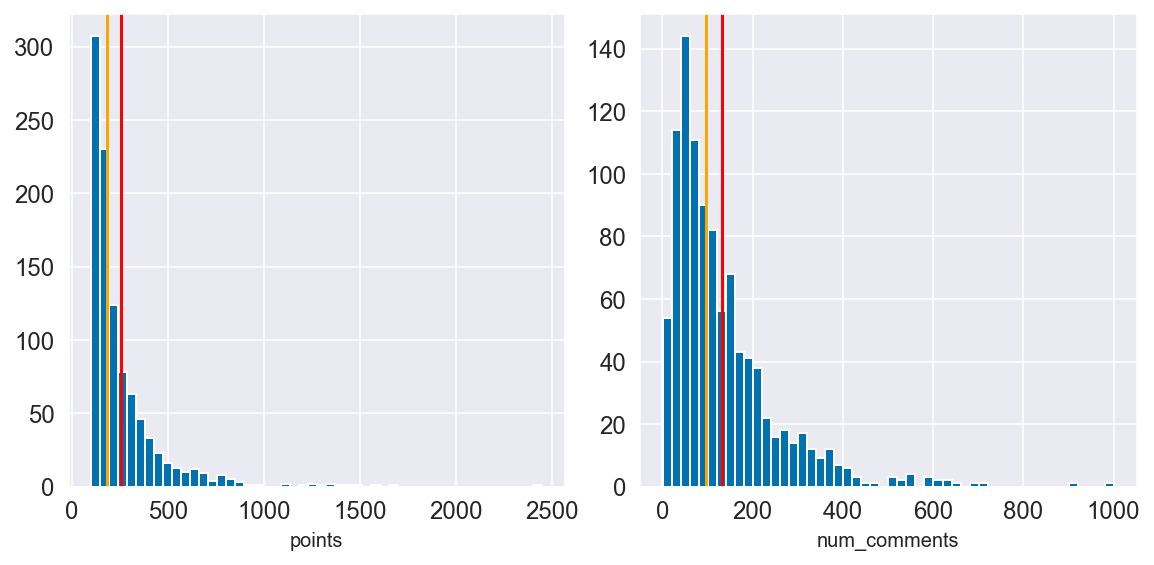

In [30]:
def dist_plot(df, cols=[], bins=50, figsize=(20,4)):
    # Multi axes plotting.
    # One Y variable against all X variables.
    fig = plt.figure(figsize=figsize)
    
    for i, col in enumerate(cols):
        fig.add_subplot(figsize[1] / 4, 5, 1+i)
        plt.xlabel(col)
        
        plt.hist(df[col], bins=bins)
        plt.axvline(df[col].mean(), c='red')
        plt.axvline(df[col].median(), c='orange')

    fig.tight_layout()
    plt.show()
    

pipeline.outputs[dataset_summary][0]
dist_plot(pipeline.outputs[dataset_summary][0], cols=pipeline.outputs[transform_dtypes][2]["numerical_cols"])

## Extract the domain names and create 'type' column to indicate story type. ##

Return to [Table of content:](#Table-of-content:)

---

Since I only need the domain names for frequency count when I do the analysis later, I will apply regex to extract the domains from `url`. The `url` column has very complicated patterns, so to resolve this, I copied the entire urls from the dataset into a site called [regexr](https://regexr.com/). This allows me to test my regex before applying it to the actual dataset. After checking the result from the sites, I will then paste the regex here.

As for the story type, I will follow the pattern such as Ask, Launch, and Show to suggest the type of each stories. 

__Extract domain name from `url` column.__

In [31]:
def extract_data(df, cols=[], new_cols=[], regex=[], drop_cols=[]):
    import re
    
    data_copy = df.copy()
    for i, col in enumerate(cols):
        data_copy[new_cols[i]] = data_copy[col].str.extract(regex[i], flags=re.IGNORECASE, expand=True)
    
    # Drop the column where I extract from if I don't need it.
    dropped_cols = []
    if drop_cols:
        for drop in drop_cols:
            data_copy.drop(columns=drop, inplace=True)
            dropped_cols.append(drop)
    return (data_copy, dropped_cols)

In [32]:
# Add into the 'Pipeline'.
func = extract_data
pipeline.kwargs[func] = {
    "cols": ["url"],
    "regex": [r"(?<=:\/\/)(?P<domain>[\w\-\.]+)/?"],
    "new_cols": ["domain"],
    "drop_cols": ["url"]
}
pipeline.tasks.add(parent_func=transform_dtypes, to=func, n_outputs=1)
pipeline.run(start_func=func, checkpoint=False)

pipeline.outputs[func][0]

,objectID,title,created_at,points,num_comments,domain
0,21495338,Rust 2020: GUI and Community,2019-11-09 00:00:00+00:00,152,37,raphlinus.github.io
1,21494673,Viral Tweet About Apple Card Leads to Goldman Sachs Probe,2019-11-09 00:00:00+00:00,129,148,www.bloomberg.com
2,21494295,Narcissistic CEOs weaken collaboration and integrity,2019-11-09 00:00:00+00:00,150,80,www.gsb.stanford.edu
3,21493761,"Fast Markov chains in ~20 lines of sh, grep, cut and Awk",2019-11-09 00:00:00+00:00,292,34,0x0f0f0f.github.io
4,21493410,Show HN: LuaJIT assembler/assembly language for direct bytecode programming,2019-11-09 00:00:00+00:00,127,20,github.com
...,...,...,...,...,...,...
995,21282680,DoNotPay app waits on hold for you,2019-10-17 00:00:00+00:00,130,82,techcrunch.com
996,21282647,Haskell in Production,2019-10-17 00:00:00+00:00,200,237,felixmulder.com
997,21282009,OpenBSD 6.6,2019-10-17 00:00:00+00:00,224,89,www.openbsd.org
998,21281724,DNS 101: An Introduction to Domain Name Servers,2019-10-17 00:00:00+00:00,250,38,www.redhat.com


---
__Create a new column `type` to indicate the type of the stories.__

In [33]:
def create_new_data_with_regex(df, col, new_col, regex=[], impute=[], drop=False):
    import re
    import numpy as np
    
    data_copy = df.copy()
    data_copy[new_col] = np.nan
    
    for i, rx in enumerate(regex):
        boo = data_copy[col].str.contains(rx, flags=re.IGNORECASE)
        data_copy.loc[boo, new_col] = impute[i]
    return (data_copy,)

In [34]:
# Add into the 'Pipeline'.
func = create_new_data_with_regex
pipeline.kwargs[func] = {
    "col": "title",
    "regex": [r"\bAsk HN\b|\?$", r"\bLaunch HN\b", r"\bShow HN\b"],
    "impute": ["ask", "launch", "show"],
    "new_col": "type"
}
pipeline.tasks.add(parent_func=extract_data, to=func, n_outputs=1)
pipeline.run(start_func=func, checkpoint=True)

pipeline.outputs[func][0]

,objectID,title,created_at,points,num_comments,domain,type
0,21495338,Rust 2020: GUI and Community,2019-11-09 00:00:00+00:00,152,37,raphlinus.github.io,NaN
1,21494673,Viral Tweet About Apple Card Leads to Goldman Sachs Probe,2019-11-09 00:00:00+00:00,129,148,www.bloomberg.com,NaN
2,21494295,Narcissistic CEOs weaken collaboration and integrity,2019-11-09 00:00:00+00:00,150,80,www.gsb.stanford.edu,NaN
3,21493761,"Fast Markov chains in ~20 lines of sh, grep, cut and Awk",2019-11-09 00:00:00+00:00,292,34,0x0f0f0f.github.io,NaN
4,21493410,Show HN: LuaJIT assembler/assembly language for direct bytecode programming,2019-11-09 00:00:00+00:00,127,20,github.com,show
...,...,...,...,...,...,...,...
995,21282680,DoNotPay app waits on hold for you,2019-10-17 00:00:00+00:00,130,82,techcrunch.com,NaN
996,21282647,Haskell in Production,2019-10-17 00:00:00+00:00,200,237,felixmulder.com,NaN
997,21282009,OpenBSD 6.6,2019-10-17 00:00:00+00:00,224,89,www.openbsd.org,NaN
998,21281724,DNS 101: An Introduction to Domain Name Servers,2019-10-17 00:00:00+00:00,250,38,www.redhat.com,NaN


In [35]:
pipeline.outputs[create_new_data_with_regex][0]["type"].unique()

array([nan, 'show', 'ask', 'launch'], dtype=object)

## Work on the missing data. ##

Return to [Table of content:](#Table-of-content:)

---

__Check the proportion of missing values.__

In [36]:
def null_rows(df):
    nulls_proportion = round(df.isnull().sum() / df.shape[0] * 100, 2)
    nulls_proportion = nulls_proportion[nulls_proportion > 0]
    nulls_sum = nulls_proportion / 100 * df.shape[0]
    
    # Filter the non-null rows and add each 'series' to 'dict'.
    dict_null_col = {}
    for col in nulls_sum.index:
        null_rows = df[col].isnull()
        null_idx = df.loc[null_rows, col].index
        dict_null_col[col] = df.iloc[null_idx, :]
    
    nulls_detail = {
        "Nulls Proportion": nulls_proportion,
        "Nulls Sum": nulls_sum,
        "Null Columns": dict_null_col
    }
    return (df, nulls_detail)

In [37]:
# Add into the 'Pipeline'.
func = null_rows
pipeline.tasks.add(parent_func=create_new_data_with_regex, to=func, n_outputs=1)
pipeline.run(start_func=func, checkpoint=False)

pipeline.outputs[func][1]["Nulls Proportion"]

domain     3.4
type      91.1
dtype: float64

---
__Check on the `domain` column.__

In [38]:
pipeline.outputs[func][1]["Null Columns"]["domain"]

,objectID,title,created_at,points,num_comments,domain,type
49,21482899,Ask HN: Starting an Anonymous Blog in 2019?,2019-11-08 00:00:00+00:00,131,80,NaN,ask
149,21461617,Ask HN: How do you make sure your servers are up as a single founder?,2019-11-06 00:00:00+00:00,440,218,NaN,ask
174,21456399,Ask HN: How is your mental health?,2019-11-05 00:00:00+00:00,162,153,NaN,ask
182,21454881,Python should take a lesson from APL: Walrus operator not needed,2019-11-05 00:00:00+00:00,102,106,NaN,NaN
283,21433526,Ask HN: How do you roll back production?,2019-11-03 00:00:00+00:00,203,152,NaN,ask
284,21433305,Ask HN: How prevalent is non-cookie-based web tracking today?,2019-11-03 00:00:00+00:00,139,63,NaN,ask
350,21419536,Ask HN: Who is hiring? (November 2019),2019-11-01 00:00:00+00:00,400,715,NaN,ask
351,21419534,Ask HN: Who wants to be hired? (November 2019),2019-11-01 00:00:00+00:00,132,262,NaN,ask
352,21419258,Ask HN: What to do after the workday?,2019-11-01 00:00:00+00:00,118,107,NaN,ask
395,21410579,Ask HN: What are some resources to improve speaking skills?,2019-10-31 00:00:00+00:00,215,69,NaN,ask


---

Titles that contain __'Ask HN'__ or __'?'__ indicate a question, while others like __'Launch HN'__ indicates product launch, and __'Show HN'__ indicates showcase. 

There are titles without __'... HN'__ that do not provide referral url also. This is because the authors wrote a list of urls in the content rather than on the designated input for url, thus they were not recorded inside the database. Probably because the designated input only allows for one url. The rest are just advertisements with email provided only or information sharing with no intention of directing the readers to other sites.

I will keep these rows since the titles remain useful for analysis still. If the readers enjoys the content, they are most likely informative or well-received regardless of the url. 

---

The nulls for the `type` column actually refers to type __"story"__. I will fill the all the nulls with __"story"__ instead. 

In [39]:
def fill_na(df, cols=[], values=[]):
    for i, col in enumerate(cols):
        df[col].fillna(value=values[i], inplace=True)
    return (df, )

In [40]:
# Add into the 'Pipeline'.
func = fill_na
pipeline.kwargs[func] = {
    "cols": ["type"],
    "values": ["story"]
}
pipeline.tasks.add(parent_func=create_new_data_with_regex, to=func, n_outputs=1)
pipeline.run(start_func=func, checkpoint=True)

pipeline.outputs[func][0]

,objectID,title,created_at,points,num_comments,domain,type
0,21495338,Rust 2020: GUI and Community,2019-11-09 00:00:00+00:00,152,37,raphlinus.github.io,story
1,21494673,Viral Tweet About Apple Card Leads to Goldman Sachs Probe,2019-11-09 00:00:00+00:00,129,148,www.bloomberg.com,story
2,21494295,Narcissistic CEOs weaken collaboration and integrity,2019-11-09 00:00:00+00:00,150,80,www.gsb.stanford.edu,story
3,21493761,"Fast Markov chains in ~20 lines of sh, grep, cut and Awk",2019-11-09 00:00:00+00:00,292,34,0x0f0f0f.github.io,story
4,21493410,Show HN: LuaJIT assembler/assembly language for direct bytecode programming,2019-11-09 00:00:00+00:00,127,20,github.com,show
...,...,...,...,...,...,...,...
995,21282680,DoNotPay app waits on hold for you,2019-10-17 00:00:00+00:00,130,82,techcrunch.com,story
996,21282647,Haskell in Production,2019-10-17 00:00:00+00:00,200,237,felixmulder.com,story
997,21282009,OpenBSD 6.6,2019-10-17 00:00:00+00:00,224,89,www.openbsd.org,story
998,21281724,DNS 101: An Introduction to Domain Name Servers,2019-10-17 00:00:00+00:00,250,38,www.redhat.com,story


## Demonstrate using 'Pipeline' to chain all the functions together. ##

Return to [Table of content:](#Table-of-content:)

In [41]:
pipeline = Pipeline()

# Map all the associated keywords to the relevant functions. 
pipeline.kwargs = {
    dataset_detail: {"filename": "csv/hn_stories.csv"},
    
    transform_dtypes: {
        "obj_convert_cols": ["objectID"], "num_convert_cols": ["points", "num_comments"],
        "dt_convert_cols": ["created_at"], "dt_first": "infer"},
    
    extract_data: {
        "cols": ["url"], "regex": [r"(?<=:\/\/)(?P<domain>[\w\-\.]+)/?"], 
        "new_cols": ["domain"], "drop_cols": ["url"]},
    
    create_new_data_with_regex: {
        "col": "title", "regex": [r"\bAsk HN\b|\?$", r"\bLaunch HN\b", r"\bShow HN\b"],
        "impute": ["ask", "launch", "show"], "new_col": "type"},
    
    fill_na: {"cols": ["type"], "values": ["story"]}
}

# Dataset exploration.
pipeline.tasks.add(dataset_detail, n_outputs=1)
pipeline.tasks.add(parent_func=dataset_detail, to=transform_dtypes, n_outputs=1)
pipeline.tasks.add(parent_func=transform_dtypes, to=dataset_summary, n_outputs=1)
pipeline.run(checkpoint=False)

# Data extraction.
pipeline.tasks.add(parent_func=transform_dtypes, to=extract_data, n_outputs=1)
pipeline.run(start_func=extract_data, checkpoint=False)
pipeline.tasks.add(parent_func=extract_data, to=create_new_data_with_regex, n_outputs=1)
pipeline.run(start_func=create_new_data_with_regex, checkpoint=True)

# Work on missing data. 
pipeline.tasks.add(parent_func=create_new_data_with_regex, to=null_rows, n_outputs=1)
pipeline.run(start_func=null_rows, checkpoint=False)
pipeline.tasks.add(parent_func=create_new_data_with_regex, to=fill_na, n_outputs=1)
pipeline.run(start_func=fill_na, checkpoint=True)

pipeline.outputs.keys()

dict_keys([<function dataset_detail at 0x1a2306b7b8>, <function transform_dtypes at 0x10fb521e0>, <function dataset_summary at 0x10fa78598>, <function extract_data at 0x1a23fb89d8>, <function create_new_data_with_regex at 0x1a2427b488>, <function null_rows at 0x1a2429f0d0>, <function fill_na at 0x1a2429f8c8>])

---
__Overview display of the internal `Graph`.__

In [42]:
internal_graph = check_internal_graph(pipeline, output=False)
internal_graph["Graph"]

{<function __main__.dataset_detail(filename)>: [<function __main__.transform_dtypes(df, obj_convert_cols=None, dt_convert_cols=None, dt_first='year', dt_only=True, num_convert_cols=None, cat_convert_cols=None, cat_order=[None])>],
 <function __main__.transform_dtypes(df, obj_convert_cols=None, dt_convert_cols=None, dt_first='year', dt_only=True, num_convert_cols=None, cat_convert_cols=None, cat_order=[None])>: [<function __main__.dataset_summary(df)>,
  <function __main__.extract_data(df, cols=[], new_cols=[], regex=[], drop_cols=[])>],
 <function __main__.dataset_summary(df)>: [],
 <function __main__.extract_data(df, cols=[], new_cols=[], regex=[], drop_cols=[])>: [<function __main__.create_new_data_with_regex(df, col, new_col, regex=[], impute=[], drop=False)>],
 <function __main__.create_new_data_with_regex(df, col, new_col, regex=[], impute=[], drop=False)>: [<function __main__.null_rows(df)>,
  <function __main__.fill_na(df, cols=[], values=[])>],
 <function __main__.null_rows(df)

In [43]:
internal_graph["Function Running Order"]

[<function __main__.dataset_detail(filename)>,
 <function __main__.transform_dtypes(df, obj_convert_cols=None, dt_convert_cols=None, dt_first='year', dt_only=True, num_convert_cols=None, cat_convert_cols=None, cat_order=[None])>,
 <function __main__.dataset_summary(df)>,
 <function __main__.extract_data(df, cols=[], new_cols=[], regex=[], drop_cols=[])>,
 <function __main__.create_new_data_with_regex(df, col, new_col, regex=[], impute=[], drop=False)>,
 <function __main__.null_rows(df)>,
 <function __main__.fill_na(df, cols=[], values=[])>]

In [44]:
internal_graph["N Outputs"]

{<function __main__.dataset_detail(filename)>: 1,
 <function __main__.transform_dtypes(df, obj_convert_cols=None, dt_convert_cols=None, dt_first='year', dt_only=True, num_convert_cols=None, cat_convert_cols=None, cat_order=[None])>: 1,
 <function __main__.dataset_summary(df)>: 1,
 <function __main__.extract_data(df, cols=[], new_cols=[], regex=[], drop_cols=[])>: 1,
 <function __main__.create_new_data_with_regex(df, col, new_col, regex=[], impute=[], drop=False)>: 1,
 <function __main__.null_rows(df)>: 1,
 <function __main__.fill_na(df, cols=[], values=[])>: 1}

## Notes for future reference. ##

__List of things to take note:__

* Pipeline unable to run on `Directed Cyclic Graph` structure.  
* All functions must return in `tuple` even if there is only 1 output. Else, `Pipeline` will raise an error.
* If the same function — with `to = None` — is run twice, `Directed Cyclic Graph.add()` will create a duplicate of that function. 

Return to [Table of content:](#Table-of-content:)